In [2]:
pip install backtrader

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import backtrader as bt
import time

# CSV 파일 경로
file_path = "./Recent_BTC_1day.csv"

# CSV 파일을 pandas 데이터프레임으로 불러오기
btc_data = pd.read_csv(file_path)

# 열 이름을 backtrader에서 사용하기 쉽게 변경
btc_data = btc_data.rename(columns={
    'Open_time': 'datetime',
    '시가': 'open',
    '고가': 'high', 
    '저가': 'low',
    '종가': 'close',
    '거래량': 'volume'
})

# backtrader에 필요 없는 열 제거
btc_data = btc_data[['datetime', 'open', 'high', 'low', 'close', 'volume']]

# datetime 컬럼을 datetime 타입으로 변환하고 인덱스로 설정
btc_data['datetime'] = pd.to_datetime(btc_data['datetime'])
btc_data.set_index('datetime', inplace=True)

In [2]:
# backtrader 데이터피드로 변환
class CustomData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('openinterest', -1),
    )

data_feed = CustomData(dataname=btc_data)

In [ ]:
pip install torch

In [4]:
#데이터 준비
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
# 시계열 데이터를 훈련용과 테스트용으로 분할
train_size = int(len(btc_data) * 0.8)
train_data = btc_data[:train_size]
test_data = btc_data[train_size:]

# MinMaxScaler로 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))

# 'close' 컬럼을 정규화
train_scaled = scaler.fit_transform(train_data[['close']])
test_scaled = scaler.transform(test_data[['close']])

# 입력 데이터와 출력 데이터 준비 (예시: 30일 데이터를 보고 다음 날을 예측)
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # 30일 간의 데이터를 사용
        y.append(data[i + time_step, 0])  # 다음 날 가격 예측
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_scaled)
X_test, y_test = create_dataset(test_scaled)

# 데이터를 PyTorch 텐서로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 배치 차원 추가 (배치 크기, 타임스텝, 특성 수)
X_train = X_train.unsqueeze(-1)
X_test = X_test.unsqueeze(-1)


In [5]:
#gru 모델 정의
import torch
import torch.nn as nn

class GRUNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU 층 정의
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        # 출력층 정의
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 초기 은닉 상태
        out, _ = self.gru(x, h0)  # GRU 연산
        out = out[:, -1, :]  # 마지막 time step의 출력 사용
        out = self.fc(out)  # 예측 출력
        return out


In [6]:
#모델 학습
# 모델 파라미터 설정
input_size = 1  # 'close' 가격만 사용
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001

# 모델, 손실 함수, 옵티마이저 정의
model = GRUNetwork(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()  # 회귀 문제이므로 MSELoss 사용
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습
for epoch in range(num_epochs):
    model.train()
    
    # 학습
    outputs = model(X_train)
    loss = criterion(outputs.squeeze(), y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0664
Epoch [20/100], Loss: 0.0404
Epoch [30/100], Loss: 0.0180
Epoch [40/100], Loss: 0.0018
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0012
Epoch [70/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0006
Epoch [90/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0005


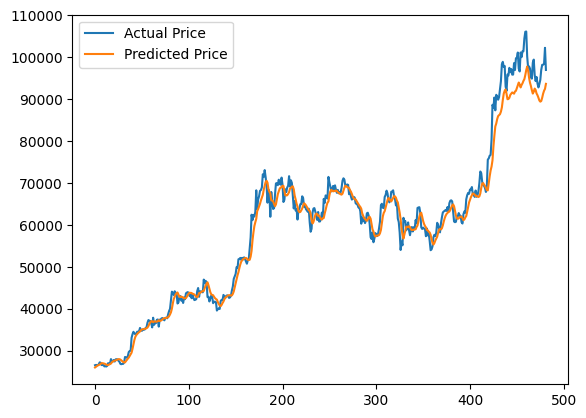

In [7]:
#예측
model.eval()
with torch.no_grad():
    predicted = model(X_test).squeeze()

# 예측 결과의 복원 (정규화된 값 복원)
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# 예측값과 실제값을 비교
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.legend()
plt.show()


In [23]:
# 날짜 정보 추가
dates = btc_data.index[train_size + self.time_step + 1:].values  # 테스트 데이터의 날짜 정보

# 예측값과 실제값을 DataFrame으로 결합
result_df = pd.DataFrame({
    'Date': dates,
    'Actual Price': y_test.flatten(),
    'Predicted Price': predicted.flatten()
})

# CSV 파일로 저장
result_df.to_csv('predicted_vs_actual_with_dates.csv', index=False)

# 결과 출력
print("CSV 파일로 저장되었습니다: predicted_vs_actual_with_dates.csv")

NameError: name 'self' is not defined

In [21]:
import backtrader as bt
import numpy as np

# 예측값을 위한 클래스를 정의
class PredictionStrategy(bt.Strategy):
    params = (
        ('model', None),  # 학습된 모델을 전달할 변수
        ('scaler', None),  # 정규화 스케일러
        ('time_step', 30),  # 예측을 위한 time step
    )

    def __init__(self):
        self.model = self.p.model
        self.scaler = self.p.scaler
        self.time_step = self.p.time_step
        self.data_close = self.datas[0].close  # 실제 종가 데이터를 가져옵니다.

    def next(self):
        # 시점에 맞는 데이터를 가져와서 모델에 입력
        if len(self) < self.time_step:
            return  # 아직 예측에 충분한 데이터가 없다면 건너뜁니다.

        # 최근 30일의 종가 데이터를 가져옵니다.
        recent_data = [self.data_close.get(i) for i in range(-self.time_step, 0)]
        recent_data = np.array(recent_data).reshape(-1, 1)
        
        # 데이터를 정규화합니다.
        scaled_data = self.scaler.transform(recent_data)
        scaled_data = torch.tensor(scaled_data, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

        # 모델 예측
        self.model.eval()
        with torch.no_grad():
            predicted_scaled = self.model(scaled_data).squeeze()
        
        # 예측값 복원
        predicted_price = self.scaler.inverse_transform(predicted_scaled.reshape(-1, 1))[0][0]
        actual_price = self.data_close[0]  # 현재 가격

        # 전략 실행: 예측 가격이 실제 가격보다 3% 이상 높으면 매수, 1% 이하로 낮으면 매도
        if predicted_price > actual_price * 1.03:  # 예측 가격이 3% 이상 높으면 매수
            if not self.position:
                self.buy()  # 매수
        elif predicted_price < actual_price * 0.99:  # 예측 가격이 1% 이하로 낮으면 매도
            if self.position:
                self.sell()  # 매도

In [22]:
# Backtrader 설정
cerebro = bt.Cerebro()
# 데이터를 Backtrader 형식으로 변환
data = data_feed  # 이미 준비된 CustomData로 데이터를 전달
# 모델과 스케일러 전달
strategy = cerebro.addstrategy(PredictionStrategy, model=model, scaler=scaler)
# 데이터 추가
cerebro.adddata(data)
# 초기 자본 설정
cerebro.broker.set_cash(10000)
# 거래 수수료 설정
cerebro.broker.setcommission(commission=0.001)
# 슬리피지 설정 (옵션)
cerebro.broker.set_slippage_perc(0.001)
# 시작
cerebro.run()

# 결과 출력
print(f'Final Portfolio Value: {cerebro.broker.getvalue()}')
# 결과를 시각화
cerebro.plot()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (30,) + inhomogeneous part.

매수 조건: 예측 가격(self.predicted_price)이 실제 가격(current_price)보다 3% 이상 높으면 매수합니다. 즉, self.predicted_price > current_price * 1.03일 때 매수를 하게 됩니다.
매도 조건: 예측 가격이 실제 가격보다 1% 낮으면 매도합니다. 즉, self.predicted_price < current_price * 0.99일 때 매도를 하게 됩니다.

In [15]:
# backtrader 설정
cerebro = bt.Cerebro()

# 데이터 로딩
data = bt.feeds.PandasData(dataname=btc_data)  # 앞서 로드한 비트코인 데이터를 사용

# GRU 모델을 전략에 전달하여 실행
cerebro.adddata(data)
cerebro.addstrategy(GRUStrategy, model=model)

# 초기 자본 설정
cerebro.broker.set_cash(10000)

# 거래 수수료 설정 (옵션)
cerebro.broker.setcommission(commission=0.001)

# 실행
cerebro.run()

# 결과 출력
print(f'Final Portfolio Value: {cerebro.broker.getvalue():.2f}')

# 성과 시각화
cerebro.plot()

2018-01-31 SELL ORDER EXECUTED: Predicted Price = 2.8533108234405518, Current Price = 10285.1
Final Portfolio Value: -74650.66


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]